In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


In [3]:
df = pd.read_csv("Data/zainfaisal_pakistan_concrete_data.csv")
print(f"Reading dataset... Total row: {df.shape[0]} rows")

df_local = pd.read_csv("Data/localdataset.csv")
print(f"Reading dataset... Total row: {df_local.shape[0]} rows")

def process_kaggle_data(df):
    recipe_cols = [
        'Cement', 'Blast Furnace Slag', 'Fly Ash', 
        'Water', 'Superplasticizer', 
        'Coarse Aggregate', 'Fine Aggregate'
    ]

    df[recipe_cols] = df[recipe_cols].round(3)
    df_filtered = df[df['Age'].isin([7, 28])].copy()

    df_grouped = df_filtered.groupby(recipe_cols + ['Age'])['Strength'].mean().reset_index()
    df_pivot = df_grouped.pivot_table(
        index=recipe_cols, 
        columns='Age', 
        values='Strength'
    ).reset_index()
    df_clean = df_pivot.dropna(subset=[7, 28])
    df_clean = df_clean.rename(columns={7: 'Strength_7', 28: 'Strength_28'})
    print(f"Original Rows: {len(df)}")
    print(f"Usable Paired Mixes Found: {len(df_clean)}")
    
    return df_clean[['Strength_7', 'Strength_28']]


Reading dataset... Total row: 1030 rows
Reading dataset... Total row: 227 rows


In [4]:
# --- STEP 1: TRAIN BASE MODEL (ON KAGGLE) ---

# Process the Kaggle data to get pairs
kaggle_pairs = process_kaggle_data(df)

# X = 7-Day Strength, Y = 28-Day Strength
X_kaggle = kaggle_pairs[['Strength_7']]
y_kaggle = kaggle_pairs['Strength_28']

# We use Linear Regression here because the strength gain curve is usually highly linear/logarithmic
base_model = LinearRegression()
base_model.fit(X_kaggle, y_kaggle)

print(f"Base Model trained. Coefficient: {base_model.coef_[0]:.2f}")
print("Meaning: For every 1 MPa at 7 days, we expect {:.2f} MPa at 28 days (before weather adjustment).".format(base_model.coef_[0]))

Original Rows: 1030
Usable Paired Mixes Found: 114
Base Model trained. Coefficient: 1.07
Meaning: For every 1 MPa at 7 days, we expect 1.07 MPa at 28 days (before weather adjustment).


In [5]:
# --- PART 3: TRAINING THE CORRECTION MODEL ---

# 1. Generate Base Predictions (What the Lab Model thinks will happen)
# This assumes Standard Temperature (~20C) because that's what Kaggle is.
df_local['Base_Pred_Lab'] = base_model.predict(df_local[['Strength_7']])

# 2. Calculate the Residual (The "Temperature Effect")
# Residual = Actual Real World - Predicted Lab World
df_local['Residual'] = df_local['Strength_28'] - df_local['Base_Pred_Lab']

# 3. Train the Correction Model
# Input: Average Temperature
# Output: The deviation (Residual)
# We use Random Forest to capture non-linear effects (like the Crossover Effect)
correction_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Reshape X to be 2D array: [[35], [10], [22]...]
X_correction = df_local[['avgTemp']]
y_correction = df_local['Residual']

correction_model.fit(X_correction, y_correction)

print("\nSUCCESS: Correction Model Trained on Temperature.")


SUCCESS: Correction Model Trained on Temperature.


In [9]:
def predict_with_temperature(strength_7, avg_temp):
    """
    Predicts 28-day strength using 7-day data + Temperature correction.
    Now silences warnings by using DataFrames.
    """
    # 1. Prepare Inputs as DataFrames (Matches training format)
    # The column names MUST match what you trained with
    input_base = pd.DataFrame([[strength_7]], columns=['Strength_7'])
    input_corr = pd.DataFrame([[avg_temp]], columns=['avgTemp'])
    
    # 2. Get the Standard Lab Prediction
    base_pred = base_model.predict(input_base)[0]
    
    # 3. Get the Temperature Correction
    temp_correction = correction_model.predict(input_corr)[0]
    
    final_pred = base_pred + temp_correction
    
    return {
        "7_Day_Input": strength_7,
        "Avg_Temp": avg_temp,
        "Lab_Curve_Pred": round(base_pred, 2),
        "Temp_Correction": round(temp_correction, 2),
        "Final_Prediction": round(final_pred, 2)
    }

# Retest
print("\n--- REFINED SCENARIO TEST ---")
print("Hot (35C):", predict_with_temperature(25, 35.0))
print("Std (20C):", predict_with_temperature(25, 20.0))


--- REFINED SCENARIO TEST ---
Hot (35C): {'7_Day_Input': 25, 'Avg_Temp': 35.0, 'Lab_Curve_Pred': np.float64(37.86), 'Temp_Correction': np.float64(-4.88), 'Final_Prediction': np.float64(32.97)}
Std (20C): {'7_Day_Input': 25, 'Avg_Temp': 20.0, 'Lab_Curve_Pred': np.float64(37.86), 'Temp_Correction': np.float64(-1.63), 'Final_Prediction': np.float64(36.22)}


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
print("--- 1. Training Base Model (Random Forest) ---")

# 1. Split Kaggle Data into Train (80%) and Test (20%)
# This allows us to check accuracy on data the model hasn't seen.
X_k = kaggle_pairs[['Strength_7']]
y_k = kaggle_pairs['Strength_28']

X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_k, y_k, test_size=0.2, random_state=42)

# 2. Train Random Forest Base Model
base_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
base_model.fit(X_train_k, y_train_k)

# 3. Check Accuracy (On Test Data)
preds_k = base_model.predict(X_test_k)
mae_k = mean_absolute_error(y_test_k, preds_k)
r2_k = r2_score(y_test_k, preds_k)

print(f"Base Model Accuracy (Lab Conditions):")
print(f"   > MAE: {mae_k:.2f} MPa (Average Error)")
print(f"   > R2 Score: {r2_k:.2f} (1.0 is perfect)")

# OPTIONAL: Retrain on ALL data for the final pipeline to get maximum performance
base_model.fit(X_k, y_k) 


# --- PART 3: CORRECTION MODEL (LOCAL) - TRAINING & EVALUATION ---

print("\n--- 2. Training Correction Model (Temperature) ---")

# 1. Create Base Predictions (Lab Standard) for Local Data
# NOTE: Using DataFrame to avoid the warning you saw earlier
input_base_local = df_local[['Strength_7']] # Use double brackets to keep it a DataFrame
df_local['Base_Pred_Lab'] = base_model.predict(input_base_local)

# 2. Calculate Residuals (Actual - Base)
df_local['Residual'] = df_local['Strength_28'] - df_local['Base_Pred_Lab']

# 3. Split Local Data for Evaluation
X_l = df_local[['avgTemp']]
y_l = df_local['Residual']

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_l, y_l, test_size=0.2, random_state=42)

# 4. Train Correction Model
correction_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
correction_model.fit(X_train_l, y_train_l)

# 5. Evaluate the Correction
preds_l_resid = correction_model.predict(X_test_l)
mae_l = mean_absolute_error(y_test_l, preds_l_resid)

print(f"Correction Model Accuracy (Predicting the Error):")
print(f"   > MAE: {mae_l:.2f} MPa")


# --- PART 4: FINAL SYSTEM ACCURACY ---

print("\n--- 3. Final System Accuracy (Combined) ---")

# Let's see how well the Combined System predicts the Test Set
# Final = Base_Model(Strength) + Correction_Model(Temp)

# Get predictions for the Local Test Set
base_preds_test = base_model.predict(df_local.loc[X_test_l.index, ['Strength_7']])
corr_preds_test = correction_model.predict(X_test_l)

final_predictions = base_preds_test + corr_preds_test
actual_values = df_local.loc[X_test_l.index, 'Strength_28']

final_mae = mean_absolute_error(actual_values, final_predictions)
final_r2 = r2_score(actual_values, final_predictions)

print(f"FINAL COMBINED MODEL ACCURACY:")
print(f"   > Mean Absolute Error: {final_mae:.2f} MPa")
print(f"   > R2 Score: {final_r2:.2f}")

if final_r2 > 0.8:
    print("\n✅ Result: The model is performing very well!")
elif final_r2 > 0.5:
    print("\n⚠️ Result: The model is okay, but could be improved.")
else:
    print("\n❌ Result: The model is struggling. Check your data quality.")

--- 1. Training Base Model (Random Forest) ---
Base Model Accuracy (Lab Conditions):
   > MAE: 4.58 MPa (Average Error)
   > R2 Score: 0.84 (1.0 is perfect)

--- 2. Training Correction Model (Temperature) ---
Correction Model Accuracy (Predicting the Error):
   > MAE: 1.89 MPa

--- 3. Final System Accuracy (Combined) ---
FINAL COMBINED MODEL ACCURACY:
   > Mean Absolute Error: 1.89 MPa
   > R2 Score: -0.13

❌ Result: The model is struggling. Check your data quality.


Training Random Forest Models...
Done.

   MODEL ACCURACY REPORT
1. BASE MODEL (Lab Data Only)
   MAE: 4.58 MPa  (Lower is better)
   R² : 0.84       (Closer to 1.0 is better)
------------------------------
2. FINAL COMBINED SYSTEM (Real World)
   MAE: 2.05 MPa
   R² : -0.45


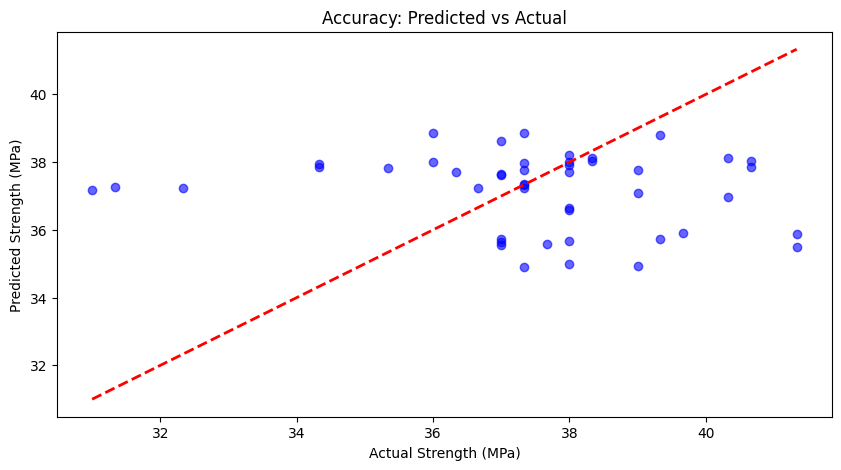

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# --- 1. PREPARE THE DATA ---
# (Assumes kaggle_pairs and df_local are already loaded)

# A. Split Kaggle Data (To test Base Model)
X_kaggle = kaggle_pairs[['Strength_7']]
y_kaggle = kaggle_pairs['Strength_28']
X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_kaggle, y_kaggle, test_size=0.2, random_state=42)

# B. Split Local Data (To test Correction Model)
# First, generate the "Base Prediction" so we know the residual
base_rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
base_rf.fit(X_train_k, y_train_k) # Train on 80% of Kaggle data

# Prepare Local Data
input_base_local = df_local[['Strength_7']]
df_local['Base_Pred'] = base_rf.predict(input_base_local)
df_local['Residual'] = df_local['Strength_28'] - df_local['Base_Pred']

X_local = df_local[['avgTemp']]
y_local = df_local['Residual']
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_local, y_local, test_size=0.2, random_state=42)

# --- 2. TRAIN MODELS ---

print("Training Random Forest Models...")

# Train Base Model (Already fitted above, but this is the logical step)
# base_rf is the "Lab Curve" model

# Train Correction Model
corr_rf = RandomForestRegressor(
    n_estimators=100, 
    max_depth=5, 
    random_state=42)
corr_rf = RandomForestRegressor(
    n_estimators=200, 
    max_depth=3,        # Reduced from 5
    min_samples_leaf=5, # Added constraint
    random_state=42
)
corr_rf.fit(X_train_l, y_train_l)

print("Done.")

# --- 3. PRINT ACCURACY REPORT ---

# Evaluate Base Model (Kaggle Test Set)
pred_k = base_rf.predict(X_test_k)
mae_k = mean_absolute_error(y_test_k, pred_k)
r2_k = r2_score(y_test_k, pred_k)

print("\n" + "="*30)
print("   MODEL ACCURACY REPORT")
print("="*30)
print(f"1. BASE MODEL (Lab Data Only)")
print(f"   MAE: {mae_k:.2f} MPa  (Lower is better)")
print(f"   R² : {r2_k:.2f}       (Closer to 1.0 is better)")
print("-" * 30)

# Evaluate Combined System (Local Test Set)
# System = Base_Prediction + Correction_Prediction
base_part = base_rf.predict(df_local.loc[X_test_l.index, ['Strength_7']])
corr_part = corr_rf.predict(X_test_l)
final_pred = base_part + corr_part
actual_vals = df_local.loc[X_test_l.index, 'Strength_28']

mae_final = mean_absolute_error(actual_vals, final_pred)
r2_final = r2_score(actual_vals, final_pred)

print(f"2. FINAL COMBINED SYSTEM (Real World)")
print(f"   MAE: {mae_final:.2f} MPa")
print(f"   R² : {r2_final:.2f}")
print("="*30)

# --- 4. VISUALIZATION (Actual vs Predicted) ---
plt.figure(figsize=(10, 5))
plt.scatter(actual_vals, final_pred, color='blue', alpha=0.6)
plt.plot([actual_vals.min(), actual_vals.max()], [actual_vals.min(), actual_vals.max()], 'r--', lw=2)
plt.xlabel('Actual Strength (MPa)')
plt.ylabel('Predicted Strength (MPa)')
plt.title('Accuracy: Predicted vs Actual')
plt.show()

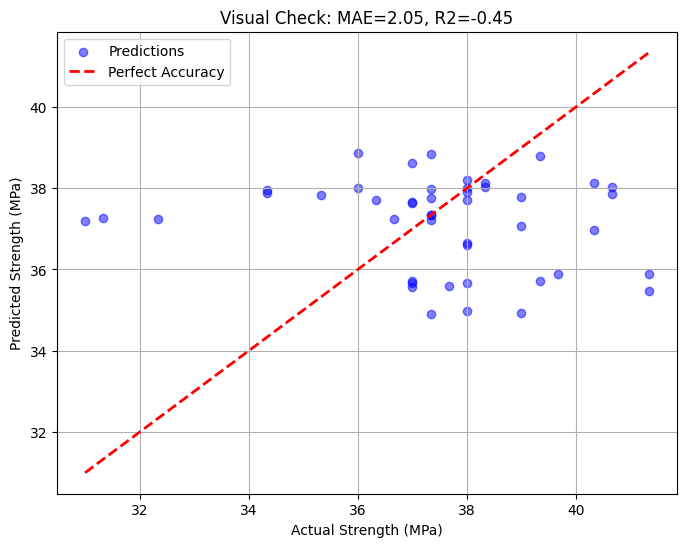

In [17]:
# 1. Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(actual_vals, final_pred, color='blue', alpha=0.5, label='Predictions')

# 2. Add the "Perfect Prediction" Line (Diagonal)
min_val = min(actual_vals.min(), final_pred.min())
max_val = max(actual_vals.max(), final_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Accuracy')

plt.xlabel('Actual Strength (MPa)')
plt.ylabel('Predicted Strength (MPa)')
plt.title(f'Visual Check: MAE={mae_final:.2f}, R2={r2_final:.2f}')
plt.legend()
plt.grid(True)
plt.show()